Loading results from 2025_11_16-22_50_50...
Found 21 recordings for mouse1
Found 21 recordings for mouse2

--- Analysis DataFrame Created ---
                                               video  frame  mouse1_syllable  \
0  Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_f...      0               16   
1  Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_f...      1               16   
2  Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_f...      2               16   
3  Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_f...      3               16   
4  Test 10_WT2-WT3_cage1_TestDLC_Resnet50_10_19_f...      4               16   

   mouse2_syllable  
0               14  
1               14  
2               14  
3               14  
4               14  

Total frames in analysis: 564933


--- ANALYSIS 1: Top 10 Syllable Frequencies ---

Syllable Frequencies (Mouse 1)
mouse1_syllable
23    68680
14    64330
6     58989
8     51426
2     40361
1     36769
13    35814
11    33118
22    26630
21    25812

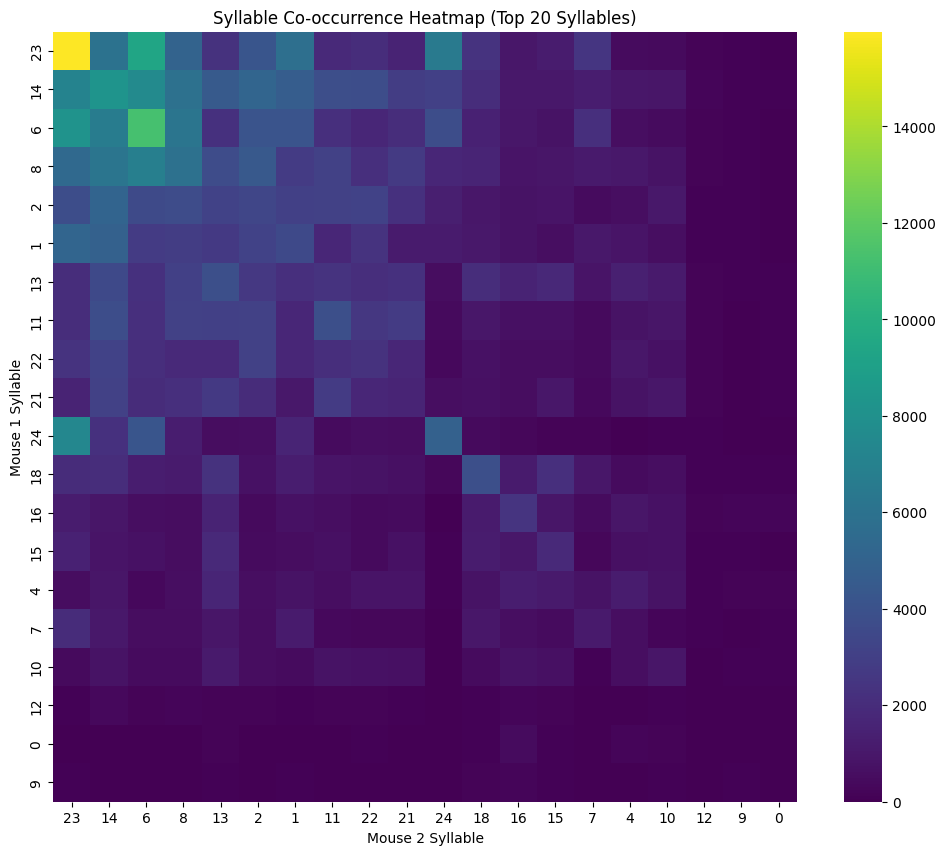



--- ANALYSIS 3: The Lag Matrix ---
Building 10x10 lag matrix (P(M2 | M1 onset) within 1.0s)...
Lag Matrix (P(M2_syll | M1_syll) within 1.0 sec):

(Generating lag matrix heatmap...)


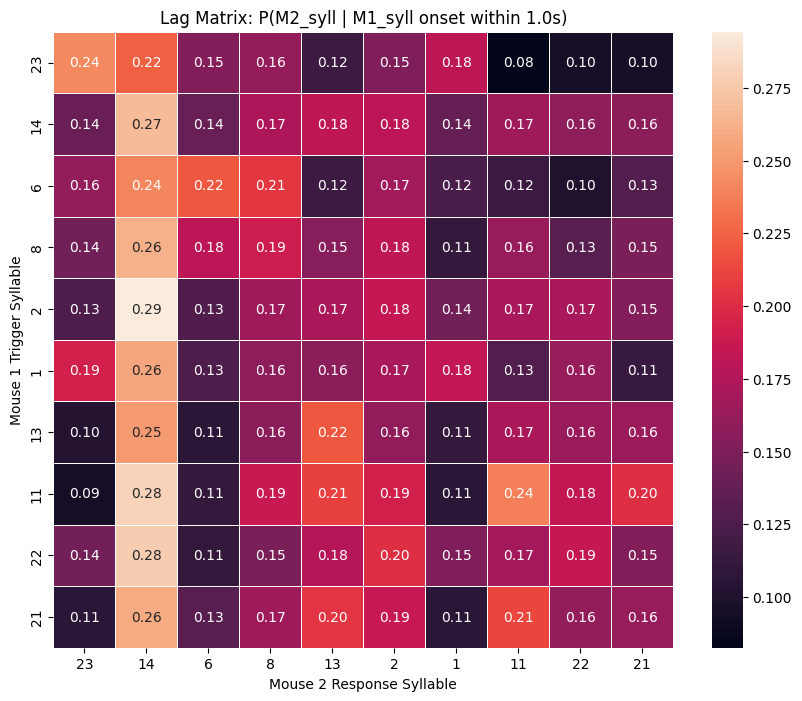



--- ANALYSIS 4: Permutation Test (Significance) ---
Running 500 shuffles for mouse1:23 -> mouse2:23...
...done in 15.89s

--- Significance Test Result ---
Pair: Mouse1-Syll23 -> Mouse2-Syll23
Real Observed Probability: 0.2423
Average Shuffled Probability: 0.1637
P-Value: 0.0020
>> Result is STATISTICALLY SIGNIFICANT (p < 0.05)


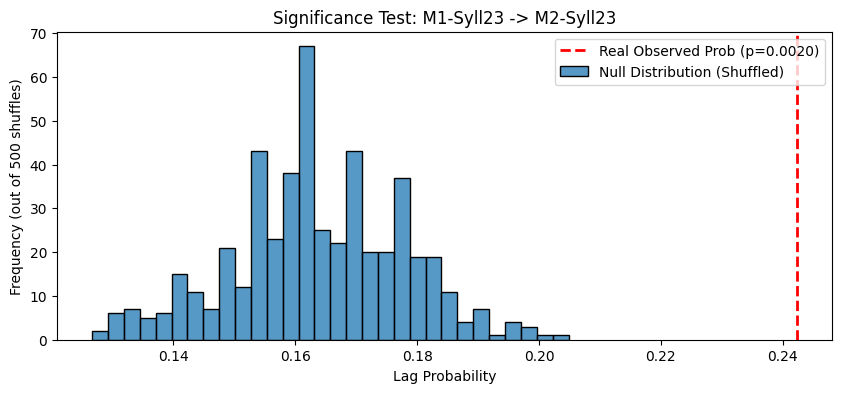



--- ANALYSIS 5: Cross-Correlogram ---


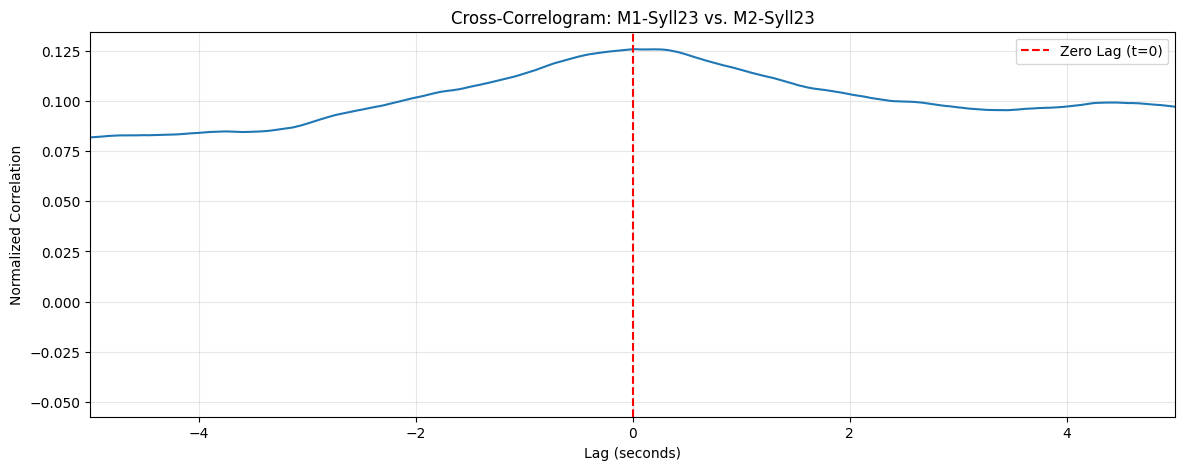



--- ANALYSIS 6: Syllable Bout Durations ---

--- Mouse 1: Average Bout Durations (Top 5 Syllables) ---
Syllable 23: Avg. duration = 75.64 frames (2.52 sec)
Syllable 14: Avg. duration = 21.23 frames (0.71 sec)
Syllable 6: Avg. duration = 63.77 frames (2.13 sec)
Syllable 8: Avg. duration = 27.84 frames (0.93 sec)
Syllable 2: Avg. duration = 22.12 frames (0.74 sec)

--- Mouse 2: Average Bout Durations (Top 5 Syllables) ---
Syllable 23: Avg. duration = 76.23 frames (2.54 sec)
Syllable 14: Avg. duration = 20.65 frames (0.69 sec)
Syllable 6: Avg. duration = 67.48 frames (2.25 sec)
Syllable 8: Avg. duration = 26.92 frames (0.90 sec)
Syllable 13: Avg. duration = 19.46 frames (0.65 sec)


--- All Analyses Complete ---


In [10]:
import keypoint_moseq as kpms
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import groupby
from scipy.signal import correlate, correlation_lags

project_dir = '/Users/yinazhou/DeepLabCut/examples/DeepLabCut/examples/11_1_identity_true'
model_name = '2025_11_16-22_50_50' # folder with results.h5
FPS = 30 

print(f"Loading results from {model_name}...")
results = kpms.load_results(project_dir, model_name)

# separate recordings by animal
all_recording_keys = list(results.keys())
mouse1_recordings = sorted([key for key in all_recording_keys if key.endswith('_mouse1')])
mouse2_recordings = sorted([key for key in all_recording_keys if key.endswith('_mouse2')])

print(f"Found {len(mouse1_recordings)} recordings for mouse1")
print(f"Found {len(mouse2_recordings)} recordings for mouse2")

# build paired dataframe for analysis
all_paired_data = []

for m1_key in mouse1_recordings:
    base_name = m1_key.replace('_mouse1', '')
    m2_key = base_name + '_mouse2'
    
    if m2_key in results:
        m1_syllables = results[m1_key]['syllable']
        m2_syllables = results[m2_key]['syllable']
        
        min_len = min(len(m1_syllables), len(m2_syllables))
        
        video_df = pd.DataFrame({
            'video': base_name,
            'frame': np.arange(min_len),
            'mouse1_syllable': m1_syllables[:min_len],
            'mouse2_syllable': m2_syllables[:min_len]
        })
        all_paired_data.append(video_df)

master_df = pd.concat(all_paired_data, ignore_index=True)

print("\n--- Analysis DataFrame Created ---")
print(master_df.head())
print(f"\nTotal frames in analysis: {len(master_df)}")


# --- BASELINE: SYLLABLE FREQUENCIES ---
print("\n\n--- ANALYSIS 1: Top 10 Syllable Frequencies ---")

print("\nSyllable Frequencies (Mouse 1)")
m1_syllable_counts = master_df['mouse1_syllable'].value_counts()
print(m1_syllable_counts.head(10))

print("\nSyllable Frequencies (Mouse 2)")
m2_syllable_counts = master_df['mouse2_syllable'].value_counts()
print(m2_syllable_counts.head(10))


# --- ANALYSIS: CO-OCCURRENCE MATRIX (SIMULTANEITY) ---
print("\n\n--- ANALYSIS 2: Syllable Co-occurrence Matrix ---")
co_occurrence_matrix = pd.crosstab(
    master_df['mouse1_syllable'],
    master_df['mouse2_syllable']
)

# Find the single most frequent pair
all_pairs = co_occurrence_matrix.stack()
print(f"\nTop 5 most frequent synchronous pairs (m1_syllable, m2_syllable):")
print(all_pairs.sort_values(ascending=False).head(5))

# --- Visualization ---
try:
    print("\n(Generating co-occurrence heatmap...)")
    top_n_heatmap = 20
    top_m1 = m1_syllable_counts.head(top_n_heatmap).index
    top_m2 = m2_syllable_counts.head(top_n_heatmap).index
    
    heatmap_data = co_occurrence_matrix.loc[top_m1, top_m2]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_data, cmap='viridis', annot=False)
    plt.title(f'Syllable Co-occurrence Heatmap (Top {top_n_heatmap} Syllables)')
    plt.xlabel('Mouse 2 Syllable')
    plt.ylabel('Mouse 1 Syllable')
    plt.show()
except Exception as e:
    print(f"Could not generate heatmap: {e}.")


# -----------------------------------------------------------------
# --- 5. HELPER FUNCTIONS for Lag & Bout Analyses ---
# -----------------------------------------------------------------

def find_lagged_responses(df, trigger_mouse, trigger_syllable, response_mouse, response_syllable, window_frames):
    """
    Finds P(Response | Trigger) within a window, based on ONSET of trigger.
    """
    trigger_col = f'{trigger_mouse}_syllable'
    response_col = f'{response_mouse}_syllable'
    
    # Get the frame indices where the *trigger syllable starts* (onset)
    trigger_series = df[trigger_col]
    trigger_indices = df.index[
        (trigger_series == trigger_syllable) & 
        (trigger_series.shift(1) != trigger_syllable)
    ]
    
    if len(trigger_indices) == 0:
        return 0.0, 0, 0 # Prob, hits, total

    hit_count = 0
    for idx in trigger_indices:
        window_start = idx + 1
        window_end = idx + window_frames
        
        if window_start >= len(df):
            continue
            
        response_window = df.loc[window_start:window_end, response_col]
        
        if (response_window == response_syllable).any():
            hit_count += 1
            
    prob = hit_count / len(trigger_indices)
    return prob, hit_count, len(trigger_indices)

def get_bout_durations(syllable_series):
    """
    Calculates the duration (in frames) of each "bout" of a syllable.
    Returns a dictionary of: {syllable: [list_of_durations]}
    """
    durations = {}
    for syllable, group in groupby(syllable_series):
        duration = len(list(group))
        if syllable not in durations:
            durations[syllable] = []
        durations[syllable].append(duration)
    return durations

def run_permutation_test(df, trigger_mouse, trigger_syll, response_mouse, response_syll, window_frames, n_shuffles=1000):
    """
    Runs a permutation test by "rolling" the response mouse's data.
    """
    real_prob, _, _ = find_lagged_responses(
        df, trigger_mouse, trigger_syll, response_mouse, response_syll, window_frames
    )
    
    if real_prob == 0.0:
        print("Real probability is 0.0, skipping shuffles.")
        return 0.0, 0.0, [] # p_val, real_prob, null_dist
        
    null_distribution = []
    shuffled_df = df.copy()
    response_col = f"{response_mouse}_syllable"
    
    print(f"Running {n_shuffles} shuffles for {trigger_mouse}:{trigger_syll} -> {response_mouse}:{response_syll}...")
    start_time = time.time()
    
    for i in range(n_shuffles):
        random_shift = np.random.randint(1000, len(shuffled_df) - 1000)
        shuffled_df[response_col] = np.roll(df[response_col], shift=random_shift)
        
        shuffled_prob, _, _ = find_lagged_responses(
            shuffled_df, trigger_mouse, trigger_syll, response_mouse, response_syll, window_frames
        )
        null_distribution.append(shuffled_prob)
        
    print(f"...done in {time.time() - start_time:.2f}s")

    n_exceeding = np.sum(np.array(null_distribution) >= real_prob)
    p_value = (n_exceeding + 1) / (n_shuffles + 1)
    
    return p_value, real_prob, null_distribution

def plot_cross_correlogram(df, trigger_mouse, trigger_syll, response_mouse, response_syll, max_lag_sec=5, fps=30):
    """
    Calculates and plots the cross-correlogram between two
    syllable event-series.
    """
    trigger_events = (df[f'{trigger_mouse}_syllable'] == trigger_syll).astype(float)
    response_events = (df[f'{response_mouse}_syllable'] == response_syll).astype(float)

    trigger_norm = trigger_events - trigger_events.mean()
    response_norm = response_events - response_events.mean()

    correlation = correlate(trigger_norm, response_norm, mode='full')
    lags_frames = correlation_lags(len(trigger_events), len(response_events), mode='full')
    lags_sec = lags_frames / fps
    
    plt.figure(figsize=(14, 5))
    norm_correlation = correlation / (len(trigger_events) * trigger_events.std() * response_events.std())
    plt.plot(lags_sec, norm_correlation)
    
    plt.title(f'Cross-Correlogram: M1-Syll{trigger_syll} vs. M2-Syll{response_syll}')
    plt.xlabel('Lag (seconds)')
    plt.ylabel('Normalized Correlation')
    plt.axvline(0, color='red', linestyle='--', label='Zero Lag (t=0)')
    plt.xlim([-max_lag_sec, max_lag_sec])
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# --- 6. ANALYSIS: LAG MATRIX (PREDICTION) ---
print("\n\n--- ANALYSIS 3: The Lag Matrix ---")

# --- Parameters ---
top_n = 10
m1_top_syllables = m1_syllable_counts.head(top_n).index
m2_top_syllables = m2_syllable_counts.head(top_n).index

window_sec = 1.0
window_f = int(window_sec * FPS)

# --- Create the matrix ---
lag_matrix = pd.DataFrame(index=m1_top_syllables, columns=m2_top_syllables, dtype=float)
lag_matrix.index.name = "M1 Trigger Syllable"
lag_matrix.columns.name = "M2 Response Syllable"

print(f"Building {top_n}x{top_n} lag matrix (P(M2 | M1 onset) within {window_sec}s)...")
for m1_syll in m1_top_syllables:
    for m2_syll in m2_top_syllables:
        prob, _, _ = find_lagged_responses(
            df=master_df,
            trigger_mouse='mouse1',
            trigger_syllable=m1_syll,
            response_mouse='mouse2',
            response_syllable=m2_syll,
            window_frames=window_f
        )
        lag_matrix.loc[m1_syll, m2_syll] = prob

print(f"Lag Matrix (P(M2_syll | M1_syll) within {window_sec} sec):")
print(lag_matrix.style.format("{:.2f}"))

# --- Visualize the Lag Matrix ---
try:
    print("\n(Generating lag matrix heatmap...)")
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        lag_matrix, 
        cmap='rocket', 
        annot=True, 
        fmt=".2f",
        linewidths=.5
    )
    plt.title(f'Lag Matrix: P(M2_syll | M1_syll onset within {window_sec}s)')
    plt.xlabel('Mouse 2 Response Syllable')
    plt.ylabel('Mouse 1 Trigger Syllable')
    plt.show()
except Exception as e:
    print(f"Could not generate heatmap: {e}.")


# --- 7. ANALYSIS: PERMUTATION TEST (SIGNIFICANCE) ---
print("\n\n--- ANALYSIS 4: Permutation Test (Significance) ---")
# --- Example Usage ---
# Let's test the significance of the top-left cell in our new matrix
try:
    trigger_syll = m1_top_syllables[0]
    response_syll = m2_top_syllables[0]

    p_val, real_prob, null_dist = run_permutation_test(
        master_df,
        trigger_mouse='mouse1',
        trigger_syll=trigger_syll,
        response_mouse='mouse2',
        response_syll=response_syll,
        window_frames=window_f,
        n_shuffles=500 # 500-1000 is good, 100 for a quick test
    )

    print(f"\n--- Significance Test Result ---")
    print(f"Pair: Mouse1-Syll{trigger_syll} -> Mouse2-Syll{response_syll}")
    print(f"Real Observed Probability: {real_prob:.4f}")
    print(f"Average Shuffled Probability: {np.mean(null_dist):.4f}")
    print(f"P-Value: {p_val:.4f}")

    if p_val < 0.05:
        print(">> Result is STATISTICALLY SIGNIFICANT (p < 0.05)")
    else:
        print(">> Result is NOT statistically significant.")

    # --- Visualize the null distribution ---
    plt.figure(figsize=(10, 4))
    sns.histplot(null_dist, kde=False, bins=30, label='Null Distribution (Shuffled)')
    plt.axvline(real_prob, color='red', linestyle='--', linewidth=2, label=f'Real Observed Prob (p={p_val:.4f})')
    plt.title(f'Significance Test: M1-Syll{trigger_syll} -> M2-Syll{response_syll}')
    plt.xlabel('Lag Probability')
    plt.ylabel('Frequency (out of 500 shuffles)')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"Could not run permutation test: {e}")


# --- 8. ANALYSIS: CROSS-CORRELOGRAM (TIMING) ---

print("\n\n--- ANALYSIS 5: Cross-Correlogram ---")
# --- Example Usage ---
# Let's use the same two syllables as the permutation test
try:
    trigger_syll = m1_top_syllables[0]
    response_syll = m2_top_syllables[0]

    plot_cross_correlogram(
        master_df,
        'mouse1', trigger_syll,
        'mouse2', response_syll,
        max_lag_sec=5, # Show a +/- 5 second window
        fps=FPS
    )
except Exception as e:
    print(f"Could not plot cross-correlogram: {e}")


# --- 9. ANALYSIS: BOUT DURATIONS (TEMPORAL STABILITY) ---
print("\n\n--- ANALYSIS 6: Syllable Bout Durations ---")

# Calculate durations for Mouse 1
m1_bout_durations = get_bout_durations(master_df['mouse1_syllable'])

print("\n--- Mouse 1: Average Bout Durations (Top 5 Syllables) ---")
for syll in m1_syllable_counts.head(5).index:
    if syll in m1_bout_durations:
        avg_duration_frames = np.mean(m1_bout_durations[syll])
        print(f"Syllable {syll}: Avg. duration = {avg_duration_frames:.2f} frames ({avg_duration_frames/FPS:.2f} sec)")

# Calculate durations for Mouse 2
m2_bout_durations = get_bout_durations(master_df['mouse2_syllable'])
print("\n--- Mouse 2: Average Bout Durations (Top 5 Syllables) ---")
for syll in m2_syllable_counts.head(5).index:
    if syll in m2_bout_durations:
        avg_duration_frames = np.mean(m2_bout_durations[syll])
        print(f"Syllable {syll}: Avg. duration = {avg_duration_frames:.2f} frames ({avg_duration_frames/FPS:.2f} sec)")

print("\n\n--- All Analyses Complete ---")